In [1]:
import pandas as pd
import numpy as np
import io
import sagemaker.amazon.common as smac
from pandas import DataFrame

import boto3
from sagemaker import get_execution_role
import sagemaker
from sagemaker import KMeans
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
role = get_execution_role()
bucket='myawsprojectmain'
sub_folder = 'netflix_recommendation_system'

In [3]:
data_key = 'netflix_titles.csv'
data_location = 's3://{}/{}/{}'.format(bucket, sub_folder, data_key)
movies = pd.read_csv(data_location, low_memory=False, delimiter=',', encoding='utf-8')
movies_save = movies
movies

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,NaN,United States,"September 25, 2021",2020,PG-13,90 min,Documentaries,"As her father nears the end of his life, filmm..."
1,s2,TV Show,Blood & Water,NaN,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t..."
2,s3,TV Show,Ganglands,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...",NaN,"September 24, 2021",2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Act...",To protect his family from a powerful drug lor...
3,s4,TV Show,Jailbirds New Orleans,NaN,NaN,NaN,"September 24, 2021",2021,TV-MA,1 Season,"Docuseries, Reality TV","Feuds, flirtations and toilet talk go down amo..."
4,s5,TV Show,Kota Factory,NaN,"Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...",India,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, Romantic TV Shows, TV ...",In a city of coaching centers known to train I...
...,...,...,...,...,...,...,...,...,...,...,...,...
8802,s8803,Movie,Zodiac,David Fincher,"Mark Ruffalo, Jake Gyllenhaal, Robert Downey J...",United States,"November 20, 2019",2007,R,158 min,"Cult Movies, Dramas, Thrillers","A political cartoonist, a crime reporter and a..."
8803,s8804,TV Show,Zombie Dumb,NaN,NaN,NaN,"July 1, 2019",2018,TV-Y7,2 Seasons,"Kids' TV, Korean TV Shows, TV Comedies","While living alone in a spooky town, a young g..."
8804,s8805,Movie,Zombieland,Ruben Fleischer,"Jesse Eisenberg, Woody Harrelson, Emma Stone, ...",United States,"November 1, 2019",2009,R,88 min,"Comedies, Horror Movies",Looking to survive in a world taken over by zo...
8805,s8806,Movie,Zoom,Peter Hewitt,"Tim Allen, Courteney Cox, Chevy Chase, Kate Ma...",United States,"January 11, 2020",2006,PG,88 min,"Children & Family Movies, Comedies","Dragged from civilian life, a former superhero..."


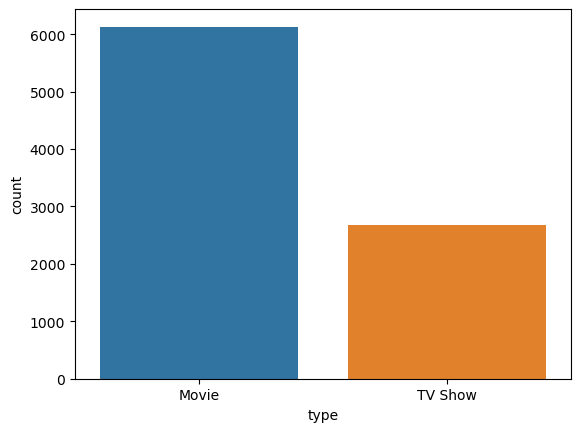

In [7]:
fig, ax = plt.subplots()
ax = sns.countplot(x=movies['type'])

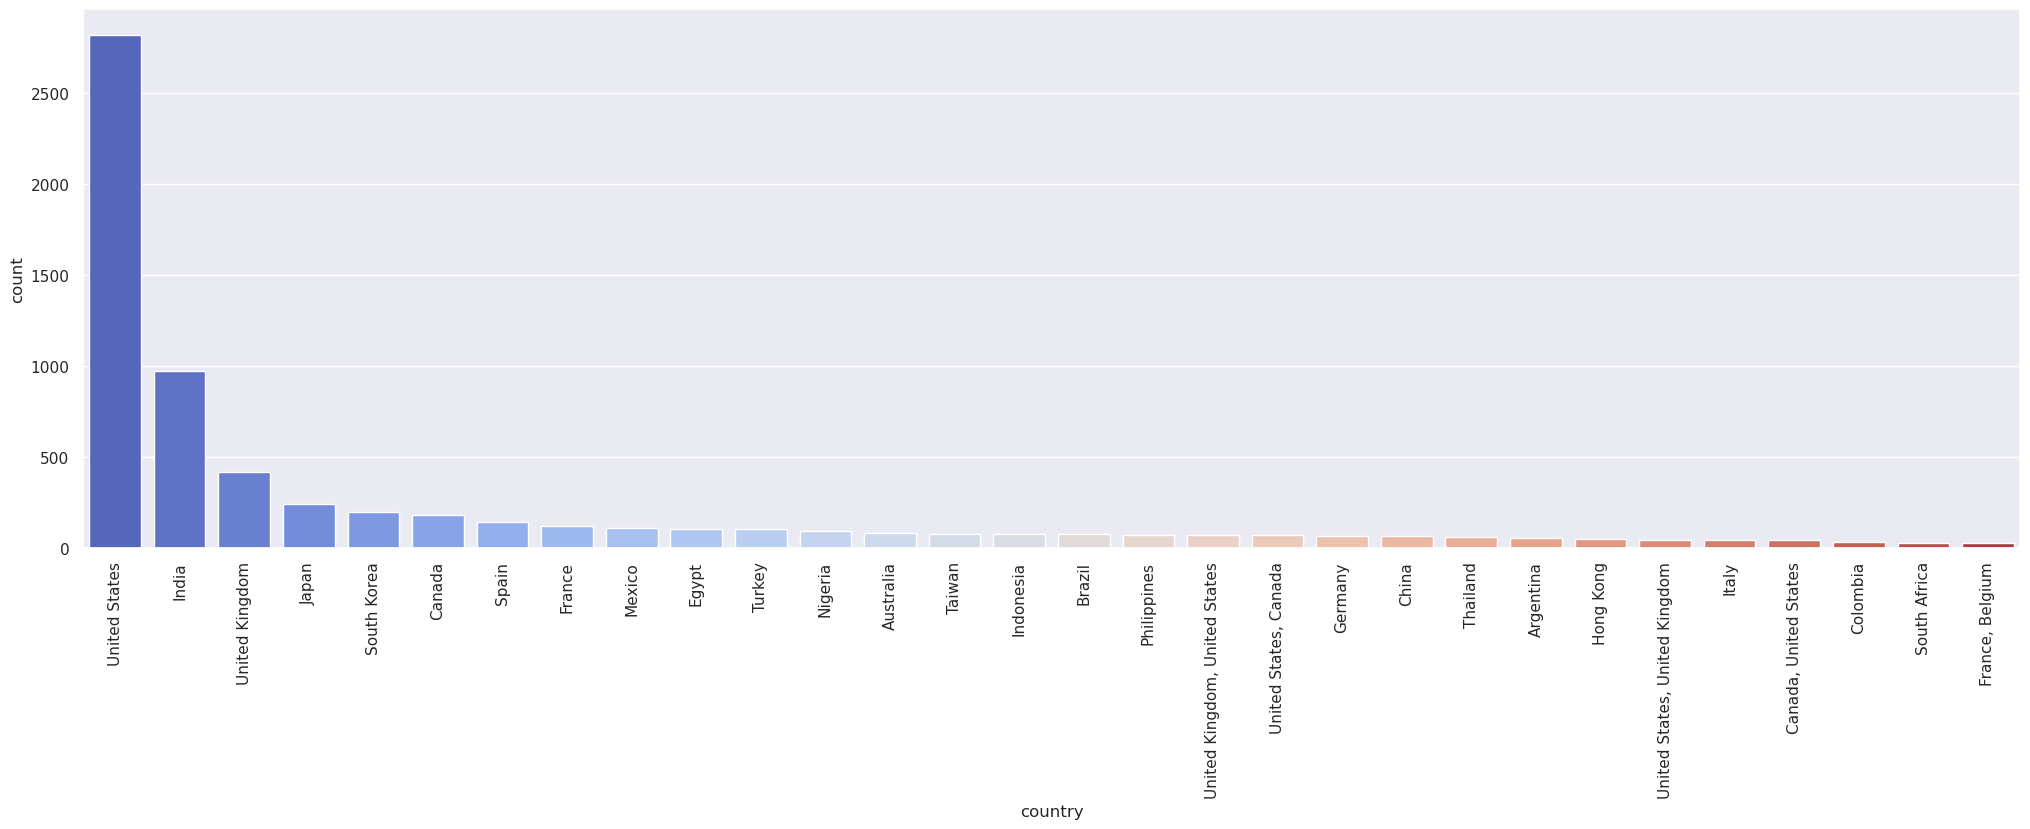

In [8]:
plt.figure(figsize=(25,7))
sns.set(style="darkgrid")
sns.countplot(x=movies['country'], palette="coolwarm",order=movies['country'].value_counts().index[0:30])
ax=plt.xticks(rotation = 90)

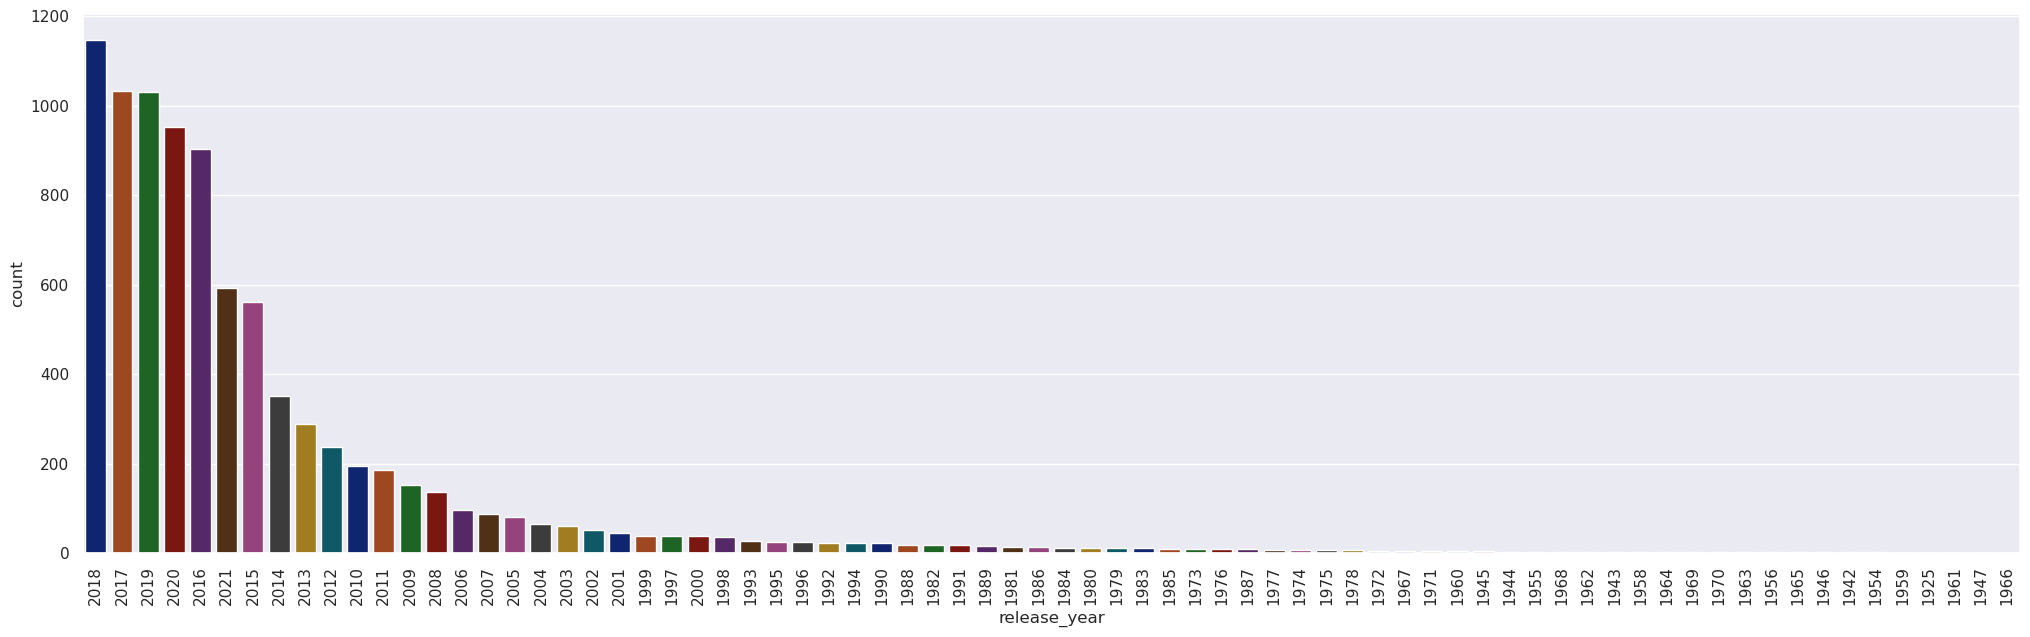

In [9]:
plt.figure(figsize=(25,7))
sns.set(style="darkgrid")
sns.countplot(x=movies['release_year'], palette="dark",order=movies['release_year'].value_counts().index[0:])
ax=plt.xticks(rotation = 90)

In [10]:
movies['rating'].value_counts()

TV-MA       3207
TV-14       2160
TV-PG        863
R            799
PG-13        490
TV-Y7        334
TV-Y         307
PG           287
TV-G         220
NR            80
G             41
TV-Y7-FV       6
NC-17          3
UR             3
74 min         1
84 min         1
66 min         1
Name: rating, dtype: int64

In [11]:
invalied = ['74 min' , '84 min' , '66 min']
movies =  movies[~movies['rating'].isin(invalied)]

In [12]:

movies.shape

(8804, 12)

In [13]:
movies['rating'].nunique()

14

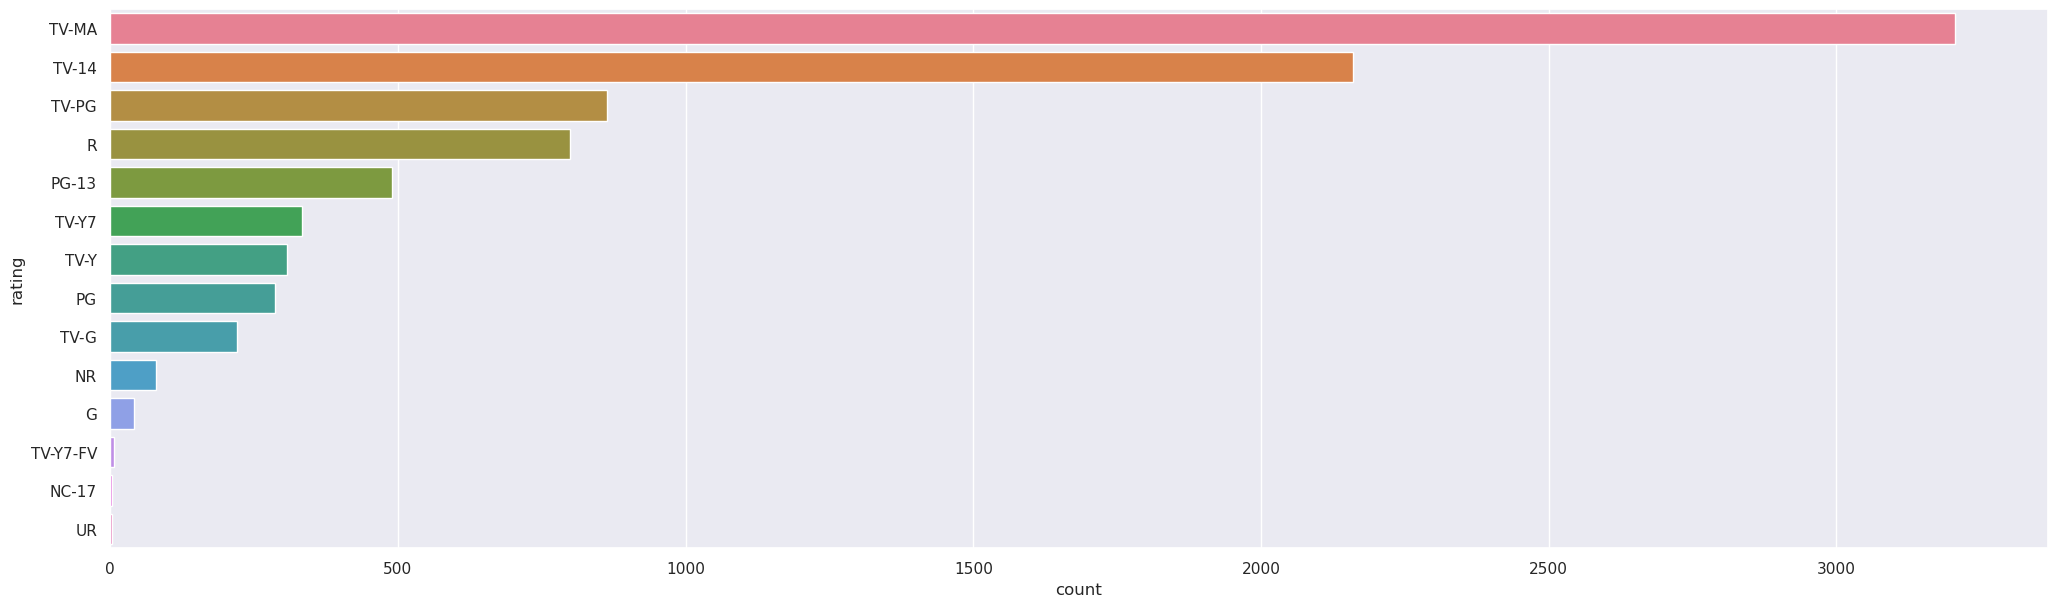

In [17]:
plt.figure(figsize=(25,7))
sns.set(style="darkgrid")
ax=sns.countplot(y=movies['rating'], palette="husl", order=movies['rating'].value_counts().index[0:])

In [18]:
movies['date_added'] = pd.to_datetime(movies['date_added'])
movies['yearmonth_added'] = pd.to_datetime(movies['date_added']).dt.strftime('%Y-%m')
movies['month_added'] = movies['date_added'].dt.month
movies['year_added'] = movies['date_added'].dt.year

/tmp/ipykernel_30487/3745441334.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movies['date_added'] = pd.to_datetime(movies['date_added'])
/tmp/ipykernel_30487/3745441334.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movies['yearmonth_added'] = pd.to_datetime(movies['date_added']).dt.strftime('%Y-%m')
/tmp/ipykernel_30487/3745441334.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

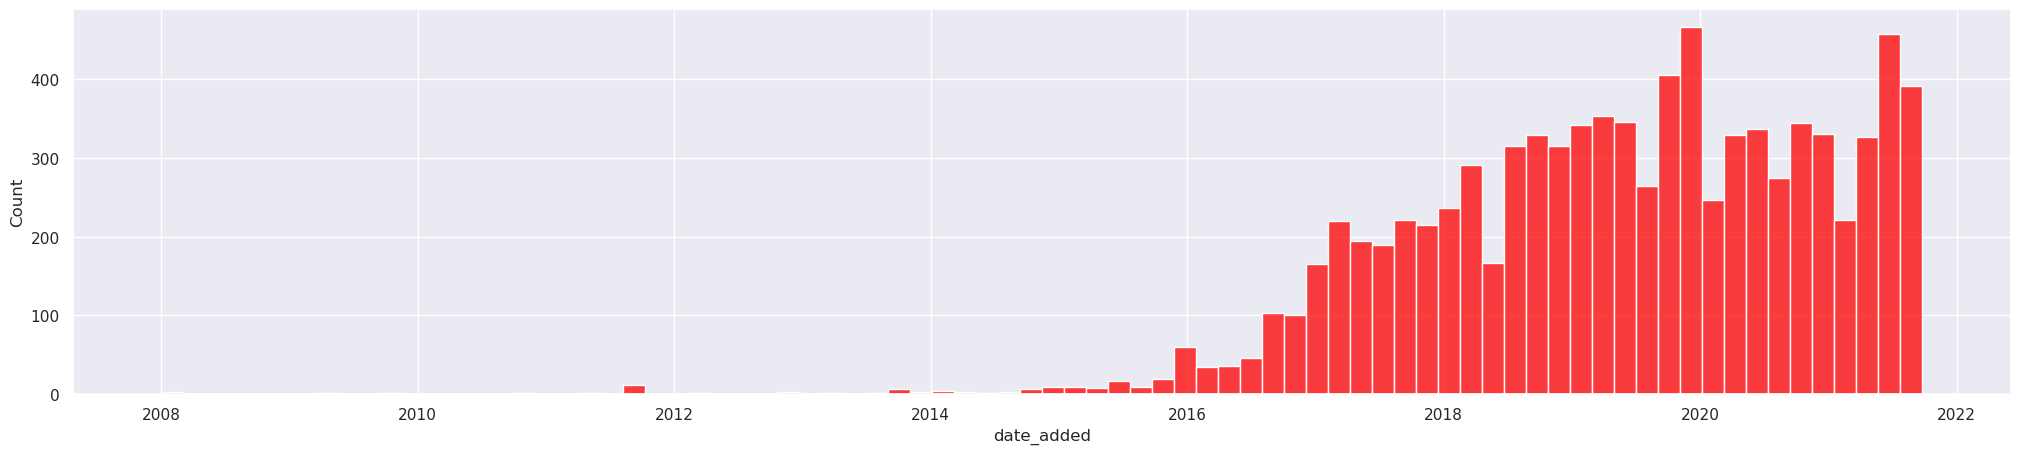

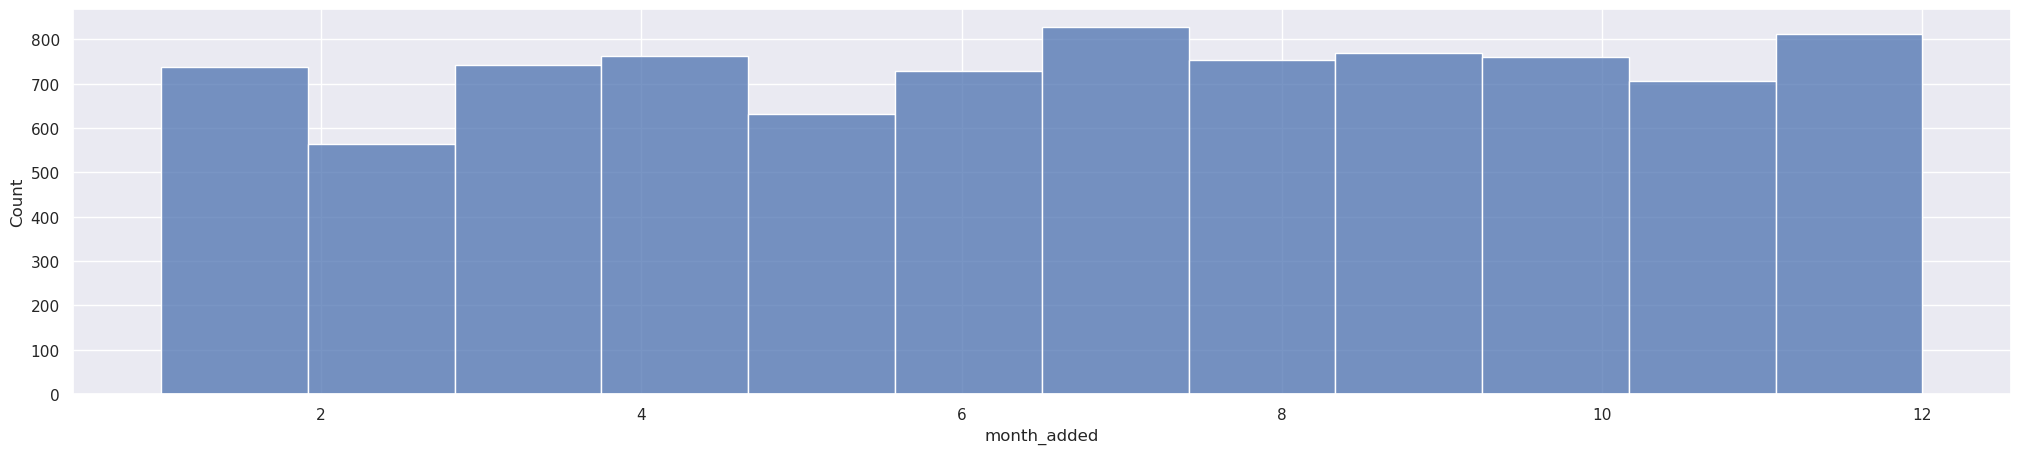

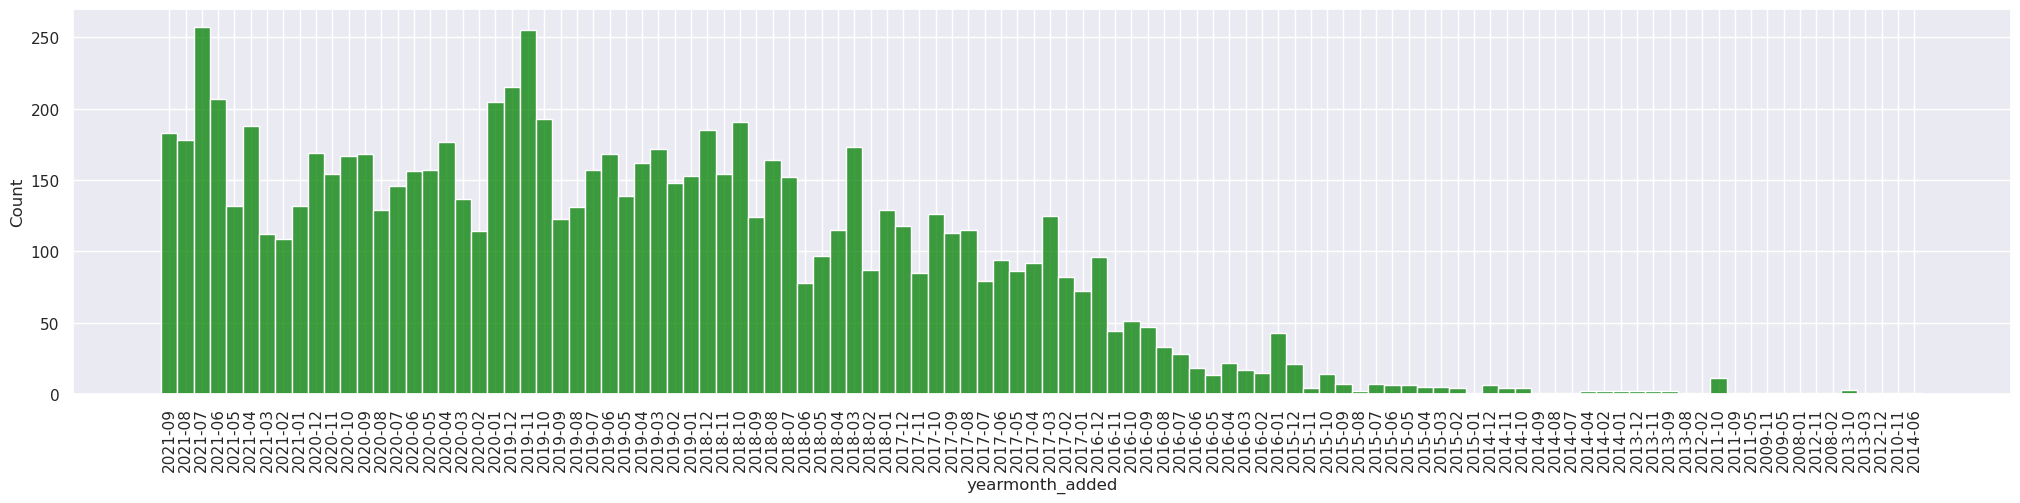

In [19]:
plt.figure(figsize=(25,5))
sns.histplot(x=movies['date_added'], bins=80, color="red")
plt.figure(figsize=(25,5))
sns.histplot(x=movies['month_added'], bins=12)
plt.figure(figsize=(25,5))
sns.histplot(x=movies['yearmonth_added'], bins=20, color="green" )
ax=plt.xticks(rotation = 90)
     

In [20]:
movies['duration'].value_counts()

1 Season     1793
2 Seasons     425
3 Seasons     199
90 min        152
94 min        146
             ... 
16 min          1
186 min         1
193 min         1
189 min         1
191 min         1
Name: duration, Length: 220, dtype: int64

In [21]:

movies.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8804 entries, 0 to 8806
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   show_id          8804 non-null   object        
 1   type             8804 non-null   object        
 2   title            8804 non-null   object        
 3   director         6170 non-null   object        
 4   cast             7979 non-null   object        
 5   country          7973 non-null   object        
 6   date_added       8794 non-null   datetime64[ns]
 7   release_year     8804 non-null   int64         
 8   rating           8800 non-null   object        
 9   duration         8804 non-null   object        
 10  listed_in        8804 non-null   object        
 11  description      8804 non-null   object        
 12  yearmonth_added  8794 non-null   object        
 13  month_added      8794 non-null   float64       
 14  year_added       8794 non-null   float64

In [22]:
df = movies.copy()
df[['title','listed_in','description']]

,title,listed_in,description
0,Dick Johnson Is Dead,Documentaries,"As her father nears the end of his life, filmm..."
1,Blood & Water,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t..."
2,Ganglands,"Crime TV Shows, International TV Shows, TV Act...",To protect his family from a powerful drug lor...
3,Jailbirds New Orleans,"Docuseries, Reality TV","Feuds, flirtations and toilet talk go down amo..."
4,Kota Factory,"International TV Shows, Romantic TV Shows, TV ...",In a city of coaching centers known to train I...
...,...,...,...
8802,Zodiac,"Cult Movies, Dramas, Thrillers","A political cartoonist, a crime reporter and a..."
8803,Zombie Dumb,"Kids' TV, Korean TV Shows, TV Comedies","While living alone in a spooky town, a young g..."
8804,Zombieland,"Comedies, Horror Movies",Looking to survive in a world taken over by zo...
8805,Zoom,"Children & Family Movies, Comedies","Dragged from civilian life, a former superhero..."


In [23]:
from sklearn.metrics.pairwise import linear_kernel
from sklearn.feature_extraction.text import TfidfVectorizer

In [24]:
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix_desc=tfidf.fit_transform(df['description'])
tfidf_matrix_genre=tfidf.fit_transform(df['listed_in'])
cosine_sim_desc = linear_kernel(tfidf_matrix_desc,tfidf_matrix_desc)
cosine_sim_genre = linear_kernel(tfidf_matrix_genre,tfidf_matrix_genre)
cosine_sim_genre

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:1671: RuntimeWarning: divide by zero encountered in true_divide
  idf = np.log(n_samples / df) + 1


array([[1.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 1.        , 0.62049891, ..., 0.        , 0.        ,
        0.11410947],
       [0.        , 0.62049891, 1.        , ..., 0.        , 0.        ,
        0.04446265],
       ...,
       [0.        , 0.        , 0.        , ..., 1.        , 0.28785966,
        0.08467461],
       [0.        , 0.        , 0.        , ..., 0.28785966, 1.        ,
        0.07125161],
       [0.        , 0.11410947, 0.04446265, ..., 0.08467461, 0.07125161,
        1.        ]])

In [25]:
indices=pd.Series(df.index,index=df['title'])
indices

title
Dick Johnson Is Dead        0
Blood & Water               1
Ganglands                   2
Jailbirds New Orleans       3
Kota Factory                4
                         ... 
Zodiac                   8802
Zombie Dumb              8803
Zombieland               8804
Zoom                     8805
Zubaan                   8806
Length: 8804, dtype: int64

In [26]:
def get_recommendations_desc(title):
    idx = indices[title]
    sim_scores_desc = list(enumerate(cosine_sim_desc[idx]))
    sim_scores_desc = sorted(sim_scores_desc, key=lambda x: x[1], reverse=True)
    sim_scores_desc = sim_scores_desc[1:11]
    movie_indices = [i[0] for i in sim_scores_desc]
    return df[['title','description','listed_in']].iloc[movie_indices]

In [27]:
get_recommendations_desc("Stranger Things")

,title,description,listed_in
4733,Rowdy Rathore,A con man uncovers a deadly secret and must sa...,"Action & Adventure, Comedies, International Mo..."
1240,Safe Haven,When a mysterious woman arrives in a small Nor...,"Dramas, Romantic Movies"
1487,Sakho & Mangane,A by-the-book police captain and a brash young...,"Crime TV Shows, International TV Shows, TV Dramas"
8198,The Autopsy of Jane Doe,A father-son team of small-town coroners perfo...,"Horror Movies, Independent Movies, Thrillers"
2419,Big Stone Gap,A single middle-aged woman who has lived her w...,"Comedies, Romantic Movies"
6518,Come and Find Me,"When his photographer girlfriend vanishes, an ...","Dramas, Thrillers"
6760,FirstBorn,A young couple fights supernatural foes in an ...,"Horror Movies, International Movies"
8026,Sinister Circle,A psychologist and her mute son confront evil ...,"Horror Movies, International Movies"
4201,Hardy Bucks,A circle of young men entertain vague ambition...,TV Comedies
1270,Sin senos sí hay paraíso,Born into a small town controlled by the mafia...,"International TV Shows, Spanish-Language TV Sh..."


In [28]:
def get_recommendations_genre(title):
    idx = indices[title]
    sim_scores_genre = list(enumerate(cosine_sim_genre[idx]))
    sim_scores_genre = sorted(sim_scores_genre, key=lambda x: x[1], reverse=True)
    sim_scores_genre = sim_scores_genre[1:11]
    movie_indices = [i[0] for i in sim_scores_genre]
    return df[['title','listed_in','description']].iloc[movie_indices]

In [29]:
get_recommendations_genre("Stranger Things")

,title,listed_in,description
3187,Nightflyers,"TV Horror, TV Mysteries, TV Sci-Fi & Fantasy","With humankind's future at stake, a group of s..."
3685,Stranger Things,"TV Horror, TV Mysteries, TV Sci-Fi & Fantasy","When a young boy vanishes, a small town uncove..."
6953,Helix,"TV Horror, TV Mysteries, TV Sci-Fi & Fantasy",While investigating a possible outbreak at an ...
241,Manifest,"TV Dramas, TV Mysteries, TV Sci-Fi & Fantasy",When a plane mysteriously lands years after ta...
3986,The OA,"TV Dramas, TV Mysteries, TV Sci-Fi & Fantasy","Seven years after vanishing from her home, a y..."
5287,The Vampire Diaries,"TV Dramas, TV Mysteries, TV Sci-Fi & Fantasy","Trapped in adolescent bodies, feuding vampire ..."
5939,The 4400,"TV Dramas, TV Mysteries, TV Sci-Fi & Fantasy",4400 people who vanished over the course of fi...
8421,The Messengers,"TV Dramas, TV Mysteries, TV Sci-Fi & Fantasy",A group of strangers who are killed by a myste...
2190,The Umbrella Academy,"TV Action & Adventure, TV Mysteries, TV Sci-Fi...","Reunited by their father's death, estranged si..."
2303,Warrior Nun,"TV Action & Adventure, TV Mysteries, TV Sci-Fi...","After waking up in a morgue, an orphaned teen ..."


In [30]:
df_1 = movies.copy()
df_1.isnull().sum()

show_id               0
type                  0
title                 0
director           2634
cast                825
country             831
date_added           10
release_year          0
rating                4
duration              0
listed_in             0
description           0
yearmonth_added      10
month_added          10
year_added           10
dtype: int64

In [31]:
df_1['director'] = df_1['director'].fillna('')
df_1['cast'] = df_1['cast'].fillna('')
df_1['text'] = df_1['title'] + ' '+df_1['director'] + ' '+ df_1['cast']+ ' ' +df_1['listed_in'] + ' '+df_1['description']

In [32]:
df_1.head()

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description,yearmonth_added,month_added,year_added,text
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,,United States,2021-09-25,2020,PG-13,90 min,Documentaries,"As her father nears the end of his life, filmm...",2021-09,9.0,2021.0,Dick Johnson Is Dead Kirsten Johnson Document...
1,s2,TV Show,Blood & Water,,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,2021-09-24,2021,TV-MA,2 Seasons,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t...",2021-09,9.0,2021.0,"Blood & Water Ama Qamata, Khosi Ngema, Gail M..."
2,s3,TV Show,Ganglands,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...",NaN,2021-09-24,2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Act...",To protect his family from a powerful drug lor...,2021-09,9.0,2021.0,"Ganglands Julien Leclercq Sami Bouajila, Tracy..."
3,s4,TV Show,Jailbirds New Orleans,,,NaN,2021-09-24,2021,TV-MA,1 Season,"Docuseries, Reality TV","Feuds, flirtations and toilet talk go down amo...",2021-09,9.0,2021.0,"Jailbirds New Orleans Docuseries, Reality TV..."
4,s5,TV Show,Kota Factory,,"Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...",India,2021-09-24,2021,TV-MA,2 Seasons,"International TV Shows, Romantic TV Shows, TV ...",In a city of coaching centers known to train I...,2021-09,9.0,2021.0,"Kota Factory Mayur More, Jitendra Kumar, Ranj..."


In [33]:
text_total = " ".join(df_1['text'])
text_total[:1000]

'Dick Johnson Is Dead Kirsten Johnson  Documentaries As her father nears the end of his life, filmmaker Kirsten Johnson stages his death in inventive and comical ways to help them both face the inevitable. Blood & Water  Ama Qamata, Khosi Ngema, Gail Mabalane, Thabang Molaba, Dillon Windvogel, Natasha Thahane, Arno Greeff, Xolile Tshabalala, Getmore Sithole, Cindy Mahlangu, Ryle De Morny, Greteli Fincham, Sello Maake Ka-Ncube, Odwa Gwanya, Mekaila Mathys, Sandi Schultz, Duane Williams, Shamilla Miller, Patrick Mofokeng International TV Shows, TV Dramas, TV Mysteries After crossing paths at a party, a Cape Town teen sets out to prove whether a private-school swimming star is her sister who was abducted at birth. Ganglands Julien Leclercq Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabiha Akkari, Sofia Lesaffre, Salim Kechiouche, Noureddine Farihi, Geert Van Rampelberg, Bakary Diombera Crime TV Shows, International TV Shows, TV Action & Adventure To protect his family from a powerful drug 

In [34]:
chars = sorted(list(set(text_total)))
vocab_size = len(chars)
print(''.join(chars))
print(vocab_size)


 !"#$%&'()*+,-./0123456789:;=?@ABCDEFGHIJKLMNOPQRSTUVWXYZ_abcdefghijklmnopqrstuvwxyz|~ ¡®²´º¿ÀÁÆÇÈÉÍÑÒÓÖØÚÜÞßàáâãäåæçèéêëìíîïðñòóôõöøùúûüýþÿāăąćČčđęěğİıŁłńňŌŘřŚśŞşŠšūůŹŻżžơșțʻ́ابةتدرشعفقكلمنهويจนผยรลหาเแ่้์Ṣẹọ​‑–—‘’“”„…くんットハリ・儿子忍海的者강공냥녀는니다대드마미반사생시영웅의잡전최탄특️
257


In [35]:
from nltk.corpus import stopwords  
from nltk.tokenize import word_tokenize  
import nltk
import re
nltk.download("popular")

[nltk_data] Downloading collection 'popular'
[nltk_data]    | 
[nltk_data]    | Downloading package cmudict to
[nltk_data]    |     /home/ec2-user/nltk_data...
[nltk_data]    |   Package cmudict is already up-to-date!
[nltk_data]    | Downloading package gazetteers to
[nltk_data]    |     /home/ec2-user/nltk_data...
[nltk_data]    |   Package gazetteers is already up-to-date!
[nltk_data]    | Downloading package genesis to
[nltk_data]    |     /home/ec2-user/nltk_data...
[nltk_data]    |   Package genesis is already up-to-date!
[nltk_data]    | Downloading package gutenberg to
[nltk_data]    |     /home/ec2-user/nltk_data...
[nltk_data]    |   Package gutenberg is already up-to-date!
[nltk_data]    | Downloading package inaugural to
[nltk_data]    |     /home/ec2-user/nltk_data...
[nltk_data]    |   Package inaugural is already up-to-date!
[nltk_data]    | Downloading package movie_reviews to
[nltk_data]    |     /home/ec2-user/nltk_data...
[nltk_data]    |   Package movie_reviews is a

True

In [36]:
def preprocess(text):
    text = text.lower()  
    text = re.sub('[^A-z]', ' ', text)
    stop_words = set(stopwords.words('english'))  
    word_tokens = word_tokenize(text)  
    lemmatizer = nltk.stem.WordNetLemmatizer()
    
    filtered_sentence = []  
    for w in word_tokens:  
        if w not in stop_words:  
            filtered_sentence.append(lemmatizer.lemmatize(w))
    filtered = ' '.join([x for x in filtered_sentence])
    return filtered.lower().strip()

In [37]:
df_1['cleaned_text'] = df_1['text'].apply(lambda x : preprocess(x))

In [39]:
df_1.head()

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description,yearmonth_added,month_added,year_added,text,cleaned_text
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,,United States,2021-09-25,2020,PG-13,90 min,Documentaries,"As her father nears the end of his life, filmm...",2021-09,9.0,2021.0,Dick Johnson Is Dead Kirsten Johnson Document...,dick johnson dead kirsten johnson documentary ...
1,s2,TV Show,Blood & Water,,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,2021-09-24,2021,TV-MA,2 Seasons,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t...",2021-09,9.0,2021.0,"Blood & Water Ama Qamata, Khosi Ngema, Gail M...",blood water ama qamata khosi ngema gail mabala...
2,s3,TV Show,Ganglands,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...",NaN,2021-09-24,2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Act...",To protect his family from a powerful drug lor...,2021-09,9.0,2021.0,"Ganglands Julien Leclercq Sami Bouajila, Tracy...",gangland julien leclercq sami bouajila tracy g...
3,s4,TV Show,Jailbirds New Orleans,,,NaN,2021-09-24,2021,TV-MA,1 Season,"Docuseries, Reality TV","Feuds, flirtations and toilet talk go down amo...",2021-09,9.0,2021.0,"Jailbirds New Orleans Docuseries, Reality TV...",jailbird new orleans docuseries reality tv feu...
4,s5,TV Show,Kota Factory,,"Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...",India,2021-09-24,2021,TV-MA,2 Seasons,"International TV Shows, Romantic TV Shows, TV ...",In a city of coaching centers known to train I...,2021-09,9.0,2021.0,"Kota Factory Mayur More, Jitendra Kumar, Ranj...",kota factory mayur jitendra kumar ranjan raj a...


In [40]:
text_total = " ".join(df_1['cleaned_text'])
chars = sorted(list(set(text_total)))
vocab_size = len(chars)
print(''.join(chars))
print(vocab_size)

 _abcdefghijklmnopqrstuvwxyz
28


In [41]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer()
text_features = vectorizer.fit_transform(df_1['cleaned_text'])

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:1671: RuntimeWarning: divide by zero encountered in true_divide
  idf = np.log(n_samples / df) + 1


In [42]:
from sklearn.metrics.pairwise import cosine_similarity
similarity_matrix = cosine_similarity(text_features)

In [43]:
def get_recommendations(title):
    idx = indices[title]
    sim_scores = list(enumerate(similarity_matrix[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:11]
    movie_indices = [i[0] for i in sim_scores]
    return df_1[['title','listed_in','description']].iloc[movie_indices]

In [44]:
get_recommendations("Stranger Things")

,title,listed_in,description
5200,Beyond Stranger Things,"Stand-Up Comedy & Talk Shows, TV Mysteries, TV...","Secrets from the ""Stranger Things 2"" universe ..."
1127,Prank Encounters,"Reality TV, TV Comedies, TV Horror",Monstrous frights meet hilarious reveals on th...
2190,The Umbrella Academy,"TV Action & Adventure, TV Mysteries, TV Sci-Fi...","Reunited by their father's death, estranged si..."
6167,Anjaan: Special Crimes Unit,"International TV Shows, TV Horror, TV Mysteries",The cases are supernatural; the police officer...
1335,The Sinner,"Crime TV Shows, TV Dramas, TV Mysteries",When a young mother inexplicably stabs a stran...
964,Things Heard & Seen,"Horror Movies, Thrillers",A young woman discovers that both her husband ...
3986,The OA,"TV Dramas, TV Mysteries, TV Sci-Fi & Fantasy","Seven years after vanishing from her home, a y..."
4809,Kiss Me First,"British TV Shows, Crime TV Shows, Internationa...",A lonely young woman hooked on a virtual reali...
8604,Top 10 Secrets and Mysteries,"British TV Shows, Docuseries, Science & Nature TV",This series investigates mysteries that persis...
241,Manifest,"TV Dramas, TV Mysteries, TV Sci-Fi & Fantasy",When a plane mysteriously lands years after ta...
